<a href="https://colab.research.google.com/github/MarcoBarroca/VI_EAFEXP_Proj3/blob/main/projetos/Rafael.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile
import pandas as pd
  
# read the dataset using the compression zip
lightcurves_train = pd.read_csv('/content/drive/MyDrive/DataP03/plasticc_train_lightcurves.csv.gz',compression='gzip')
metadata_train = pd.read_csv('/content/drive/MyDrive/DataP03/plasticc_train_metadata.csv.gz',compression='gzip')
metadata_test = pd.read_csv('/content/drive/MyDrive/DataP03/plasticc_test_metadata.csv.gz',compression='gzip')
lightcurves_extra = pd.read_csv('/content/drive/MyDrive/DataP03/plasticc_lightcurves_extra.csv.gz',compression='gzip')

In [3]:
import matplotlib.pyplot as plt
import numpy as np

##Sorteia e plota uma curva de luz

<ipython-input-5-2d88264e19b5>:11: MatplotlibDeprecationWarning: Saw kwargs ['mfc', 'markerfacecolor'] which are all aliases for 'markerfacecolor'.  Kept value from 'markerfacecolor'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  plt.plot(x,y, '.', linestyle='solid',  mfc='none', mec='b', markersize=24, markerfacecolor='white')


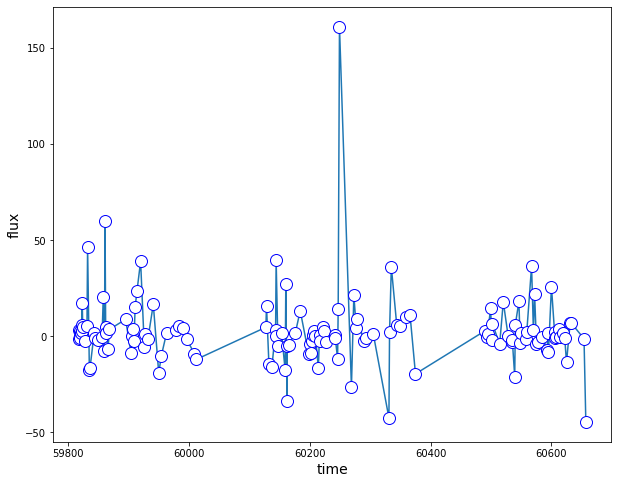

In [ ]:
x = np.random.choice(metadata_train['object_id'],1)

id = lightcurves_train[np.array(lightcurves_train['object_id']) == x]

x = np.array(id['mjd'])
y = np.array(id['flux'])

plt.figure(figsize=(10,8))
plt.xlabel('time', fontsize=14)
plt.ylabel('flux', fontsize=14)
plt.plot(x,y, '.', linestyle='solid',  mfc='none', mec='b', markersize=24, markerfacecolor='white')

#converter a unidade de tempo 

##Distribuição das clases por quantidade de aparição


    unique_values  counts
11              6     151
4              15     495
3              16     924
1              42    1193
9              52     183
13             53      30
5              62     484
12             64     102
2              65     981
8              67     208
6              88     370
0              90    2313
7              92     239
10             95     175


Text(0, 0.5, 'count')

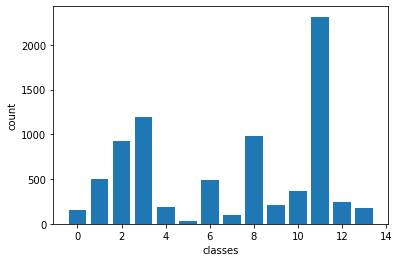

In [ ]:
classes = metadata_train["target"].value_counts().rename_axis('unique_values').reset_index(name='counts').sort_values(by='unique_values')
counts=[]

print(classes)
plt.bar(range(len(classes['unique_values'])),classes['counts'])
plt.xlabel('classes')
plt.ylabel('count')

#remover objetos vasios

##Distribuição de filtros por por quantidade de aparição

      unique_values  counts
0               615     352
1279            713     350
1610            730     330
907             745     351
513            1124     352
...             ...     ...
2593      130739978     147
6789      130755807     114
4341      130762946     134
2867      130772921     144
6313      130779836     118

[7848 rows x 2 columns]


1421705

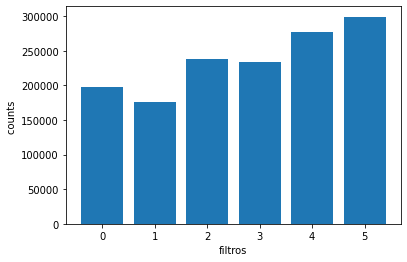

In [5]:
filtros = lightcurves_train["passband"].value_counts().rename_axis('unique_values').reset_index(name='counts').sort_values(by='unique_values')
objetos = metadata_test["object_id"].value_counts().rename_axis('unique_values').reset_index(name='counts').sort_values(by='unique_values')
counts=[]

print(objetos)
plt.bar(range(len(filtros['unique_values'])),filtros['counts'])
plt.xlabel('filtros')
plt.ylabel('counts ')

sum(filtros['counts'])


In [10]:
filtro_1 = 0
filtro_2 = 0
filtro_3 = 0
filtro_4 = 0
filtro_5 = 0
filtro_6 = 0


for x in lightcurves_train['passband']:
  if x['passband'] == 1:
    filtro_1+=1
  if int(x['passband']) == 2:
    filtro_2+=1
  if int(x['passband']) == 3:
    filtro_3+=1
  if int(x['passband']) == 4:
    filtro_4+=1
  if int(x['passband']) == 5:
    filtro_5+=1
  if int(x['passband']) == 6:
    filtro_6+=1

print(filtro_1)
'''
plt.bar(range(len(filtros['unique_values'])),filtros['counts'])
plt.xlabel('filtros')
plt.ylabel('counts ')

sum(filtros['counts'])'''


TypeError: ignored

      unique_values  counts
0               615     352
1            173059     352
2            167417     352
3            167436     352
4            167488     352
...             ...     ...
7843      100413487      55
7844       68643457      52
7845      119353712      52
7846       86237249      50
7847       49575267      47

[7848 rows x 2 columns]


Text(0, 0.5, 'counts')

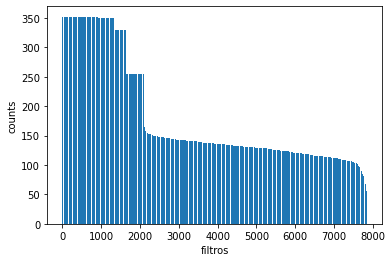

In [ ]:
pontos = lightcurves_train["object_id"].value_counts().rename_axis('unique_values').reset_index(name='counts')

counts=[]

print(pontos)
plt.bar(range(len(pontos['unique_values'])),pontos['counts'])
plt.xlabel('filtros')
plt.ylabel('counts')

#remover objetos vazios

In [ ]:
print(max(pontos["counts"]))
print(min(pontos["counts"]))

352
47


##distribuição dos fluxos

In [ ]:
flux = lightcurves_train["flux"].value_counts().rename_axis('unique_values').reset_index(name='counts')



print(flux)
plt.bar(range(len(flux['unique_values'])),flux['counts'])
plt.xlabel('filtros')
plt.ylabel('counts')

         unique_values  counts
0             0.670238       5
1            -0.289681       4
2            -0.332783       4
3             0.258622       4
4             0.421939       4
...                ...     ...
1387852      -2.651241       1
1387853       3.065438       1
1387854      -4.842262       1
1387855      -1.341718       1
1387856     -41.214264       1

[1387857 rows x 2 columns]


In [ ]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense


model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_steps, n_features)))
model.add(LSTM(50, activation='relu'))

model.add(Dense(1), activation='Softmax')
model.compile(optimizer='Nadam', loss='categorical_crossentropy', metrics = ['accuracy'])
# fit model


EPOCHS = 200
BATCH_SIZE = 32

history = network.fit(x=norm_x_train, 
                      y=y_train,
                        validation_data=(norm_x_val, y_val),
                        epochs=EPOCHS,
                        batch_size=BATCH_SIZE)